In [63]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import glob
import gzip
from scipy.signal import periodogram

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [18]:
gzipped_files = glob.glob('../datasets/aqi/bulk/**/*.csv.gz', recursive=True)
len(gzipped_files)

2711

In [20]:
# List to store individual DataFrames
dataframes = []

for file in gzipped_files:
    with gzip.open(file, 'rt') as f:
        df = pd.read_csv(f)        
        dataframes.append(df)
        
len(dataframes)

2711

In [21]:
combined_df = pd.concat(dataframes, ignore_index=True)

In [22]:
combined_df.head()

,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value,measurand
0,8415,24434,US Diplomatic Post: Dhaka-8415,2016-11-09T23:00:00+06:00,23.796373,90.424614,pm25,µg/m³,61.7,NaN
1,8415,24434,US Diplomatic Post: Dhaka-8415,2016-11-10T00:00:00+06:00,23.796373,90.424614,pm25,µg/m³,67.8,NaN
2,8415,24434,Dhaka-8415,2016-11-10T01:00:00+06:00,23.796374,90.424614,pm25,µg/m³,109.9,NaN
3,8415,24434,Dhaka-8415,2016-11-10T02:00:00+06:00,23.796374,90.424614,pm25,µg/m³,127.4,NaN
4,8415,24434,Dhaka-8415,2016-11-10T03:00:00+06:00,23.796374,90.424614,pm25,µg/m³,122.2,NaN


In [23]:
df_pivot = combined_df.pivot_table(
    index="datetime", columns="parameter", values="value", aggfunc="first"
).reset_index()
df_pivot.rename(columns={"o3": "o3 (ppm)", "pm25": "pm2.5 (µg/m³)"}, inplace=True)
df_pivot.to_csv('../datasets/aqi/generated/combined_aqi_bulk.csv', index=False, header=True)

In [24]:
df_pivot.head()

parameter,datetime,o3 (ppm),pm2.5 (µg/m³)
0,2016-11-09T23:00:00+06:00,NaN,61.7
1,2016-11-10T00:00:00+06:00,NaN,67.8
2,2016-11-10T01:00:00+06:00,NaN,109.9
3,2016-11-10T02:00:00+06:00,NaN,127.4
4,2016-11-10T03:00:00+06:00,NaN,122.2


In [25]:
df = df_pivot.copy()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parameter,,,,,,,,
o3 (ppm),9276.0,-0.119167,0.347033,-0.999,0.001,0.009,0.024,0.147
pm2.5 (µg/m³),62184.0,9.615845,304.297649,-999.000,29.000,62.000,126.000,985.000


In [26]:
date_time = pd.to_datetime(df.pop('datetime'), format='ISO8601')


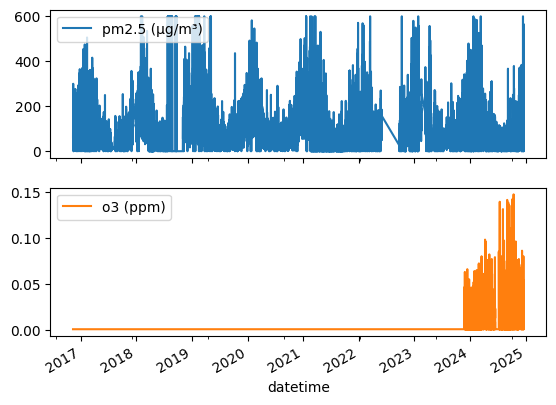

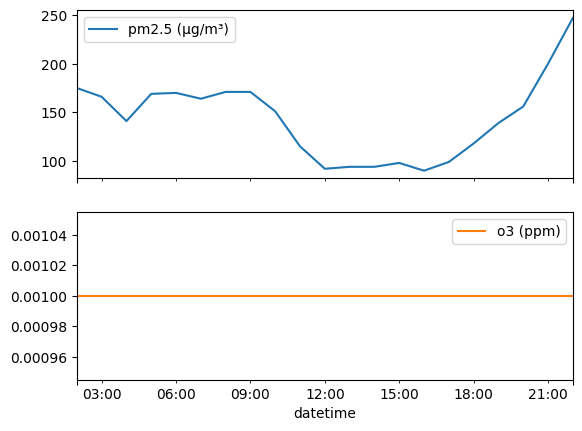

In [56]:
plot_cols = ['pm2.5 (µg/m³)', "o3 (ppm)",]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][47129:47150]
plot_features.index = date_time[47129:47150]
_ = plot_features.plot(subplots=True)

In [30]:
o3 = df['o3 (ppm)']
bad_o3 = o3 <= 0
o3[bad_o3] = 0.001

In [31]:
o3 = df['o3 (ppm)']
o3[o3.isna()] = 0.001

In [33]:
pm25 = df['pm2.5 (µg/m³)']
bad_pm25 = pm25 <= 0.0
pm25[bad_pm25] = 0.0

In [34]:
pm25 = df['pm2.5 (µg/m³)']
pm25[pm25.isna()] = 0.0

In [38]:
pm25 = df['pm2.5 (µg/m³)']
bad_pm25 = pm25 >= 600.0
pm25[bad_pm25] = 600.0

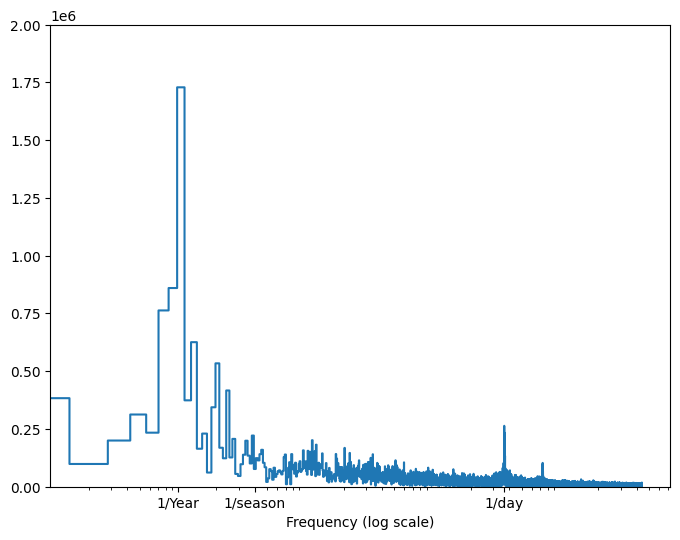

In [62]:
fft = tf.signal.rfft(df['pm2.5 (µg/m³)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['pm2.5 (µg/m³)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 365.2524], labels=['1/Year', '1/season', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [64]:
# Assuming `pm25_values` is your time-domain data
fs = 1  # Sampling frequency (adjust based on your data)
frequencies, power_spectrum = periodogram(df['pm2.5 (µg/m³)'], fs=fs)

# Peak Frequency and Magnitude
peak_freq_idx = np.argmax(power_spectrum)
peak_frequency = frequencies[peak_freq_idx]
peak_magnitude = power_spectrum[peak_freq_idx]

# Energy in specific bands (e.g., yearly, seasonal, daily)
yearly_band = (frequencies >= 1/365) & (frequencies < 1/90)  # Adjust based on your graph
yearly_energy = np.sum(power_spectrum[yearly_band])

# Spectral Centroid
spectral_centroid = np.sum(frequencies * power_spectrum) / np.sum(power_spectrum)

# Spectral Bandwidth
spectral_bandwidth = np.sqrt(np.sum((frequencies - spectral_centroid)**2 * power_spectrum) / np.sum(power_spectrum))

# Spectral Entropy
normalized_power = power_spectrum / np.sum(power_spectrum)
spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power + 1e-12))  # Avoid log(0)

In [66]:
features = {
    "peak_frequency": peak_frequency,
    "peak_magnitude": peak_magnitude,
    "yearly_energy": yearly_energy,
    "spectral_centroid": spectral_centroid,
    "spectral_bandwidth": spectral_bandwidth,
    "spectral_entropy": spectral_entropy,
}

features_df = pd.DataFrame([features])
# print(features_df)
features_df.head()


,peak_frequency,peak_magnitude,yearly_energy,spectral_centroid,spectral_bandwidth,spectral_entropy
0,0.000129,9.615130e+07,3.608725e+07,0.041015,0.088405,8.78054


In [67]:
df.head()

parameter,o3 (ppm),pm2.5 (µg/m³)
0,0.001,61.7
1,0.001,67.8
2,0.001,109.9
3,0.001,127.4
4,0.001,122.2


In [68]:
df2 = df.assign(datetime=date_time)

In [73]:
df2.head()

parameter,datetime,o3 (ppm),pm2.5 (µg/m³)
0,2016-11-09 23:00:00+06:00,0.001,61.7
1,2016-11-10 00:00:00+06:00,0.001,67.8
2,2016-11-10 01:00:00+06:00,0.001,109.9
3,2016-11-10 02:00:00+06:00,0.001,127.4
4,2016-11-10 03:00:00+06:00,0.001,122.2


In [70]:
df2.set_index('datetime', inplace=True)

In [72]:
df2 =df2.reset_index()

In [74]:
df2.to_csv('../datasets/aqi/generated/combined_aqi_bulk_modified.csv', index=False, header=True)